데이터가 ./datasets/housing 안에 있다고 가정하고 진행하겠습니다.

In [1]:
import pandas as pd
import os

In [2]:
# 디렉토리 위치 설정
HOUSING_PATH = os.path.join("datasets", "housing")

In [3]:
# 데이터를 로드하는 함수
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(HOUSING_PATH, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2.3.3 데이터 구조 훑어보기
---

In [5]:
housing = load_housing_data()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


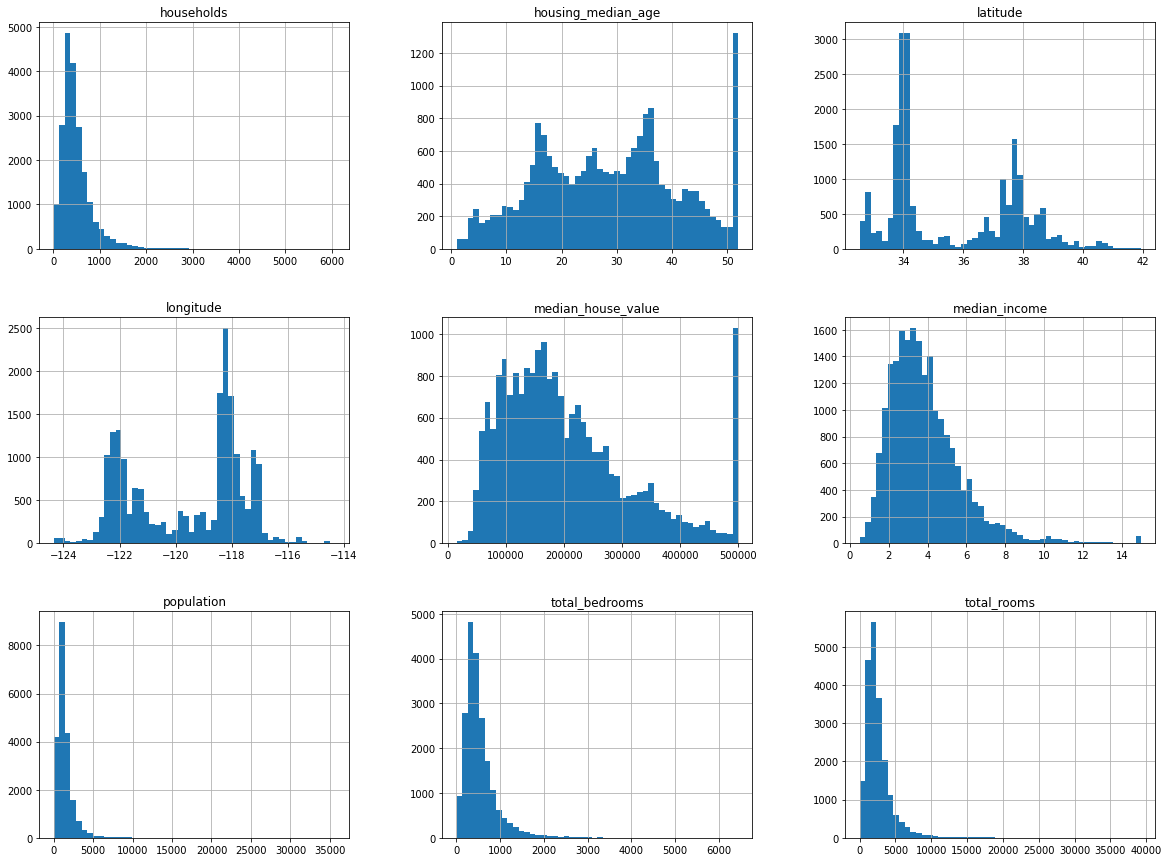

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15)) # bins는 구간 => 50개의 구간
plt.show()

In [10]:
# 노트북의 실행 결과가 동일하도록
import numpy as np

np.random.seed(42)

2.3.4 테스트 세트 만들기
---

split_train_test 는 연습을 위해 예시로 만든 것
실전에서는 사이킷런의 train_test_split을 사용

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices] # iloc : 인덱스를 기반으로 인덱싱하는 메소드

In [12]:
train_set, test_set = split_train_test(housing, 0.2)

In [13]:
len(train_set)

16512

In [14]:
len(test_set)

4128

In [15]:
from zlib import crc32

In [16]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int32(identifier)) & 0xffffffff < test_ratio * 2**32

In [17]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set] # loc : 행의 순서대로 셀렉팅

In [18]:
housing_with_id = housing.reset_index() # "index"열이 추가된 데이터프레임을 반환합니다

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [19]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] # 경도와 위도를 조합해서 ID를 만듦
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [20]:
test_set.head() # 고유하지 않은 ID 값이 생성될 수 있음

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
129,129,-122.2,37.84,30.0,2211.0,346.0,844.0,343.0,6.0666,311500.0,NEAR BAY,-122162.16
132,132,-122.2,37.84,35.0,2865.0,460.0,1072.0,443.0,7.4882,319300.0,NEAR BAY,-122162.16
135,135,-122.2,37.83,26.0,1589.0,223.0,542.0,211.0,8.4010,351200.0,NEAR BAY,-122162.17
138,138,-122.2,37.82,37.0,1229.0,181.0,420.0,176.0,7.0175,366700.0,NEAR BAY,-122162.18
139,139,-122.2,37.82,39.0,3770.0,534.0,1265.0,500.0,6.3302,362800.0,NEAR BAY,-122162.18


In [21]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [22]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


연속적인 수치형 데이터를 훈련 세트와 테스트 세트에 고르게 나누는 방법

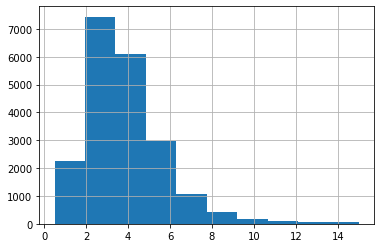

In [23]:
housing["median_income"].hist()

In [24]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4 ,5])

In [25]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

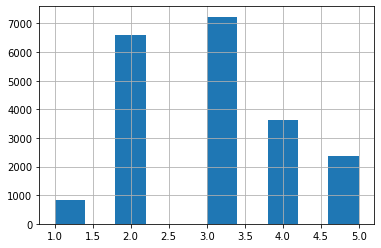

In [26]:
housing["income_cat"].hist()

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [28]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [29]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [30]:
st_train_set, st_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [31]:
st_train_set["income_cat"].value_counts() / len(st_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [32]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

2.4 데이터 이해를 위한 탐색과 시각화
---

In [33]:
housing = strat_train_set.copy()

2.4.1 지리적 데이터 시각화
---

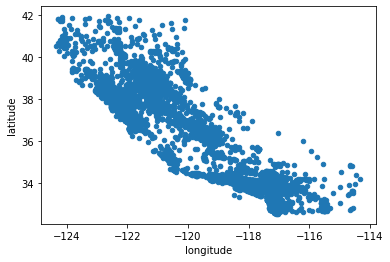

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude") # scatter : 산점도

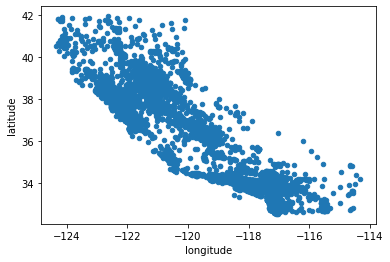

In [35]:
housing.plot.scatter(x="longitude", y="latitude") # 위 명령과 같은 내용

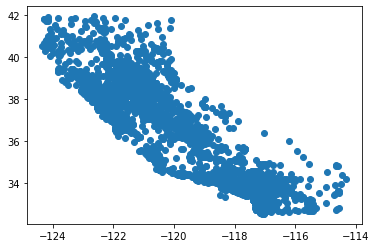

In [36]:
plt.scatter(housing["longitude"], housing["latitude"]) # 위 명령과 같은 내용

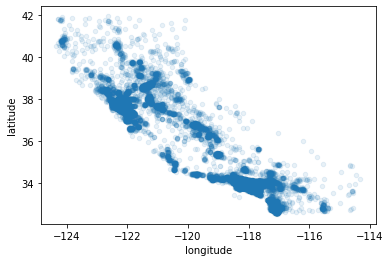

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) # alpha : 점 부분을 투명하게 만들음

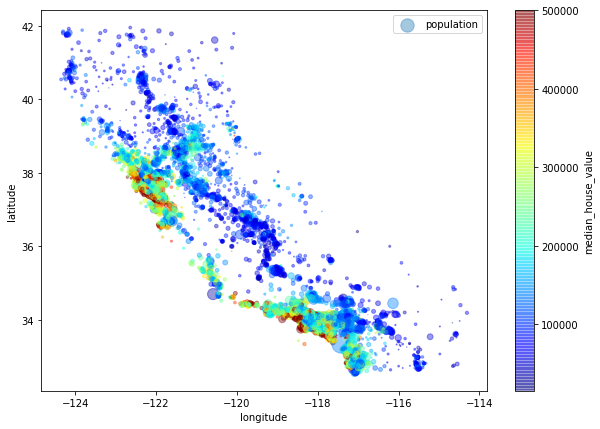

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10, 7), # s : 그리는 원의 크기(인구수에 비례)
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, # c : color (주택 중간가격), "jet" : 값이 높으면 빨갛게 낮으면 파랗게
            sharex=False) # sharex : pd의 에러 때문에 이를 입력하지 않으면 x축 레이블이 그려지지 않음

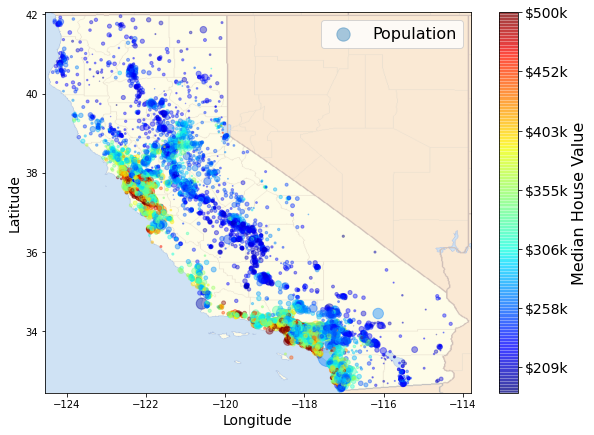

In [39]:
# 캘리포니아 지도에 맞춰서 산점도 그리기 (images/end_to_end_project)에 있다 가정
import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join("images/end_to_end_project/", "california.png"))

ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

2.4.2 상관관계 조사
---

In [40]:
corr_matrix = housing.corr()

In [41]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90ad529f60>,
      dtype=object)

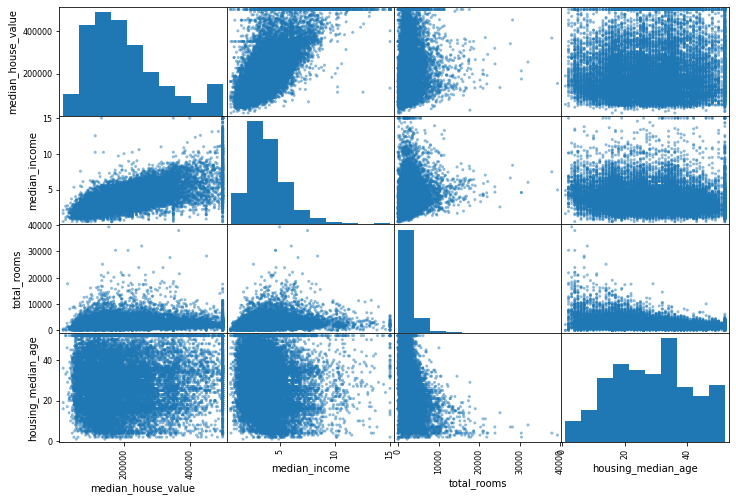

In [42]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

(0.0, 16.0, 0.0, 550000.0)

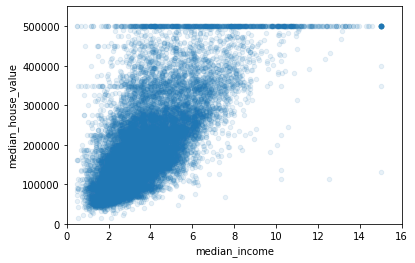

In [43]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)
plt.axis([0, 16, 0, 550000])

2.4.3 특성 조합으로 실험
----
새로운 특성을 만들음
ex) 주택마다 방이 몇개있는지   
방마다 침대가 몇개있는지   
가구당 인구수

In [44]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [45]:
corr_matrix = housing.corr()

In [46]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

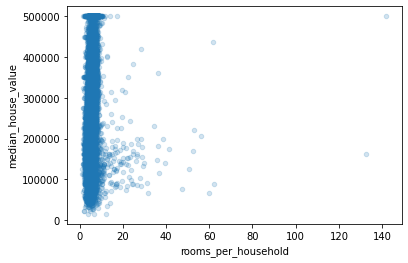

In [47]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.show()

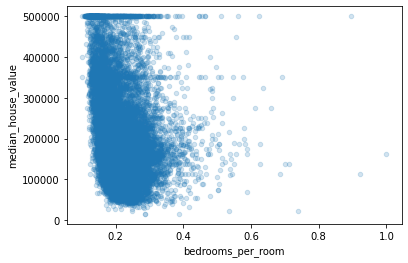

In [48]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.show()

In [49]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


2.5 머신러닝 알고리즘을 위한 데이터 준비
--

In [50]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

2.5.1 데이터 정제
----

In [51]:
# housing.dropna(subset=["total_bedrooms"]) # 옵션 1
# housing.drop("total_bedrooms", axis=1) # 옵션 2
median = housing["total_bedrooms"].median() # 옵션 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [52]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [53]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [54]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [55]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [56]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [57]:
X = imputer.transform(housing_num)

In [58]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index=housing_num.index)

2.5.2 텍스트와 범주형 특성 다루기
----

In [59]:
housing_cat = housing[["ocean_proximity"]]

In [60]:
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [61]:
from sklearn.preprocessing import OrdinalEncoder

In [62]:
ordinal_encoder = OrdinalEncoder()

In [63]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [64]:
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [65]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [66]:
from sklearn.preprocessing import OneHotEncoder

In [67]:
cat_encoder = OneHotEncoder()

In [68]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [69]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [70]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [71]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

2.5.3 나만의 변환기
-----

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args나 **kargs가 아닙니다.
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # 더 할 일이 없습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_households = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_households,
                        bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_households]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

2.5.5 변환 파이프라인
----

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                        ("attribs_adder", CombinedAttributesAdder()),
                        ("std_scaler", StandardScaler()),
                        ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [74]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),
                                  ("cat", OneHotEncoder(), cat_attribs),
                                  ])

housing_prepared = full_pipeline.fit_transform(housing)

2.6.1 훈련 세트에서 훈련하고 평가하기
------------

In [75]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
some_data = housing.iloc[:5]

In [77]:
some_labels = housing_labels.iloc[:5]

In [78]:
some_data_prepared = full_pipeline.transform(some_data)

In [79]:
print("예측 :", lin_reg.predict(some_data_prepared))

예측 : [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [80]:
print("레이블 :", list(some_labels))

레이블 : [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [81]:
from sklearn.metrics import mean_squared_error

In [82]:
housing_predictions = lin_reg.predict(housing_prepared)

In [83]:
lin_mse = mean_squared_error(housing_labels, housing_predictions)

In [84]:
lin_rmse = np.sqrt(lin_mse)

In [85]:
lin_rmse

68628.19819848922

In [86]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [87]:
housing_predictions = tree_reg.predict(housing_prepared)

In [88]:
tree_mse = mean_squared_error(housing_labels, housing_predictions)

In [89]:
tree_rmse = np.sqrt(tree_mse)

In [90]:
tree_rmse

0.0

2.6.2 교차 검증을 사용한 평가
---

In [91]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [92]:
def display_scroes(scores):
    print("점수 :", scores)
    print("평균 :", scores.mean())
    print("표준편차 :", scores.std())

In [93]:
display_scroes(tree_rmse_scores)

점수 : [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
평균 : 70666.74616904806
표준편차 : 2928.322738055112


In [94]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)

In [95]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [96]:
display_scroes(lin_rmse_scores)

점수 : [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균 : 69052.46136345083
표준편차 : 2731.674001798348


In [97]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
forest_reg = RandomForestRegressor()

In [99]:
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [100]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

In [101]:
forest_rmse

18680.294240259147

In [102]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [103]:
display_scroes(forest_scores)

점수 : [-2.45595666e+09 -2.26428886e+09 -2.46069073e+09 -2.73791999e+09
 -2.45886947e+09 -2.82544066e+09 -2.38148781e+09 -2.29252585e+09
 -2.80462247e+09 -2.50461962e+09]
평균 : -2518642212.0481915
표준편차 : 192272090.65760034


추가내용
--
전처리와 예측을 포함한 파이프라인

In [104]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [105]:
my_model = full_pipeline_with_predictor

import joblib

joblib.dump(my_model, "my_model.pkl")
# 그리고 나중에....
my_model_loaded = joblib.load("my_model.pkl")

2.7.1 그리드 탐색
---

In [106]:
from sklearn.model_selection import GridSearchCV

param_grid = [{"n_estimators" : [3, 10, 30], "max_features" : [2, 4, 6, 8]},
             {"bootstrap" : [False], "n_estimators" : [3, 10], "max_features" : [2, 3, 4]},
             ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error",
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [107]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [108]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [109]:
cvres = grid_search.cv_results_

In [110]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63433.40391736115 {'max_features': 2, 'n_estimators': 3}
56049.06443637957 {'max_features': 2, 'n_estimators': 10}
52824.848527310685 {'max_features': 2, 'n_estimators': 30}
60924.41328448018 {'max_features': 4, 'n_estimators': 3}
52713.650694157855 {'max_features': 4, 'n_estimators': 10}
50660.92190603788 {'max_features': 4, 'n_estimators': 30}
59604.01184459288 {'max_features': 6, 'n_estimators': 3}
52347.604952708156 {'max_features': 6, 'n_estimators': 10}
49923.3473574243 {'max_features': 6, 'n_estimators': 30}
59308.345962472304 {'max_features': 8, 'n_estimators': 3}
52320.77872780119 {'max_features': 8, 'n_estimators': 10}
50080.73594153239 {'max_features': 8, 'n_estimators': 30}
62160.41351492645 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54391.4645181866 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60269.48857946438 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52791.4337224519 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

2.7.4 최상의 모델과 오차 분석
---

In [111]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [112]:
feature_importances

array([7.55720671e-02, 6.39878625e-02, 4.24072059e-02, 1.82928273e-02,
       1.68924417e-02, 1.75601900e-02, 1.66881781e-02, 3.03268232e-01,
       6.31565549e-02, 1.08958622e-01, 8.44196144e-02, 8.53515062e-03,
       1.73063945e-01, 8.08024120e-05, 2.96250425e-03, 4.15380176e-03])

In [113]:
extra_attribs = ["rooms_per_hold", "pop_per_hhold", "bedrooms_per_room"]

In [114]:
cat_encoder = full_pipeline.named_transformers_["cat"]

In [115]:
cat_one_hot_attribs = list(cat_encoder.categories_[0])

In [116]:
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [117]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.303268232301214, 'median_income'),
 (0.1730639450304893, 'INLAND'),
 (0.10895862174634888, 'pop_per_hhold'),
 (0.0844196144263057, 'bedrooms_per_room'),
 (0.07557206707255014, 'longitude'),
 (0.06398786252477989, 'latitude'),
 (0.06315655490931624, 'rooms_per_hold'),
 (0.04240720593117474, 'housing_median_age'),
 (0.01829282732311651, 'total_rooms'),
 (0.017560189966804522, 'population'),
 (0.01689244166020893, 'total_bedrooms'),
 (0.01668817806453196, 'households'),
 (0.008535150622100876, '<1H OCEAN'),
 (0.0041538017589390725, 'NEAR OCEAN'),
 (0.0029625042500806965, 'NEAR BAY'),
 (8.080241203860085e-05, 'ISLAND')]

2.7.5 테스트 세트로 시스템 평가하기
---

In [118]:
final_model = grid_search.best_estimator_

In [119]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [120]:
X_test_prepared = full_pipeline.transform(X_test)

In [121]:
final_predictions = final_model.predict(X_test_prepared)

In [122]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [123]:
final_rmse

48760.26530172545

In [124]:
from scipy import stats

In [125]:
confidence = 0.95

In [126]:
squared_errors = (final_predictions  - y_test) ** 2

In [127]:
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([46743.6273187 , 50696.74792016])